# Milestone 2: EDA
## Predicting COVID-19 Cases
- Austin Rochon
- Emily Xie
- Mark Lock

<hr style="height:2pt">

## Table of Contents

0. [Introduction](#introduction)
1. [Global Data](#global)
2. [U.S. Data](#us)
3. [Analyzing Predictors](#predictors)

<a id='introduction'></a>
## Introduction
Key Questions: 
1. Given everything you have learned, if you faced this data set in the wild, how would you proceed? 
2. What are the important measures? 
3. What are the right questions to ask, and how can the data answer them?

<a id='global'></a>
## Global Data

In [154]:
import pandas as pd
import geopandas as gpd
import numpy as np

import folium
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# fetchg lobal data from the Johns Hopkins github
covid_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [18]:
# clean global data. first, transpose all date columns such that we have a single date column
# with each date entry as a row
dates = []
non_dates = ["Province/State", "Country/Region", "Lat", "Long"]
for col in covid_global.columns:
    if col not in non_dates:
        dates.append(col)
        
    
covid_global = pd.melt(covid_global, id_vars=non_dates, value_vars=dates,
                var_name="date", value_name="confirmed")

# next, simplify the column names to make analysis later easier
covid_global.rename(columns={"Province/State": "province", 
                             "Country/Region": "country",
                             "Lat": "lat",
                             "Long": "long"}, inplace=True)
covid_global.head()

,province,country,lat,long,date,confirmed
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0
1,NaN,Albania,41.1533,20.1683,1/22/20,0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0


In [19]:
max_date = covid_global["date"].max()
covid_global_mostrecent = covid_global.loc[covid_global[]]

,province,country,lat,long,date,confirmed
225,NaN,US,37.0902,-95.7129,1/22/20,1
487,NaN,US,37.0902,-95.7129,1/23/20,1
749,NaN,US,37.0902,-95.7129,1/24/20,2
1011,NaN,US,37.0902,-95.7129,1/25/20,2
1273,NaN,US,37.0902,-95.7129,1/26/20,5
...,...,...,...,...,...,...
18565,NaN,US,37.0902,-95.7129,4/1/20,213372
18827,NaN,US,37.0902,-95.7129,4/2/20,243453
19089,NaN,US,37.0902,-95.7129,4/3/20,275586
19351,NaN,US,37.0902,-95.7129,4/4/20,308850


<a id='us'></a>
## U.S. Data
For the U.S. data, we will use the [CovidTracking Project's](https://covidtracking.com/api) dataset instead of the Johns Hopkins data set. The CovidTracking project has better access to test data. We'll start by loading and cleaning that data.

In [51]:
# load daily covid data, per state
covid_us_states = pd.read_csv("https://covidtracking.com/api/v1/states/daily.csv")

In [52]:
covid_us_states.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200405,AK,185.0,6099.0,NaN,NaN,20.0,NaN,NaN,NaN,...,20.0,6284,6284,6284,2,1.0,4.0,230.0,14.0,244.0
1,20200405,AL,1796.0,11282.0,NaN,NaN,231.0,NaN,NaN,NaN,...,231.0,13078,13078,13078,1,2.0,19.0,2009.0,216.0,2225.0
2,20200405,AR,830.0,10412.0,NaN,67.0,130.0,NaN,43.0,27.0,...,130.0,11242,11242,11242,5,2.0,130.0,785.0,87.0,872.0
3,20200405,AS,0.0,20.0,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,26,20,20,60,0.0,0.0,0.0,0.0,0.0
4,20200405,AZ,2269.0,25141.0,NaN,NaN,310.0,NaN,108.0,NaN,...,310.0,27410,27410,27410,4,12.0,13.0,0.0,250.0,250.0


In [53]:
# add full state name as a column
states_dict = states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

covid_us_states["name"] = covid_us_states["state"].map(states_dict)
covid_us_states.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,name
0,20200405,AK,185.0,6099.0,NaN,NaN,20.0,NaN,NaN,NaN,...,6284,6284,6284,2,1.0,4.0,230.0,14.0,244.0,Alaska
1,20200405,AL,1796.0,11282.0,NaN,NaN,231.0,NaN,NaN,NaN,...,13078,13078,13078,1,2.0,19.0,2009.0,216.0,2225.0,Alabama
2,20200405,AR,830.0,10412.0,NaN,67.0,130.0,NaN,43.0,27.0,...,11242,11242,11242,5,2.0,130.0,785.0,87.0,872.0,Arkansas
3,20200405,AS,0.0,20.0,6.0,NaN,NaN,NaN,NaN,NaN,...,26,20,20,60,0.0,0.0,0.0,0.0,0.0,American Samoa
4,20200405,AZ,2269.0,25141.0,NaN,NaN,310.0,NaN,108.0,NaN,...,27410,27410,27410,4,12.0,13.0,0.0,250.0,250.0,Arizona


In [102]:
# next, load population data
us_states_population = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/state/detail/SCPRC-EST2019-18+POP-RES.csv")
us_states_population = us_states_population[["NAME", "POPESTIMATE2019"]]
us_states_population.rename(columns={"NAME":"name", "POPESTIMATE2019": "population"}, inplace=True)

In [103]:
# join to cases
covid_us_states = covid_us_states.merge(us_states_population, on="name", how="inner")

# create cases/population col
covid_us_states["positive_percap"] = covid_us_states["positive"] / covid_us_states["population"]
covid_us_states.head()

# join to lat/long
state_latlong = pd.read_csv("./data/statelatlong.csv")[["State", "Latitude", "Longitude"]]
state_latlong.rename(columns={"State": "state", 
                              "Latitude": "lat",
                              "Longitude": "long"}, inplace=True)
covid_us_states = covid_us_states.merge(state_latlong, on="state", how="inner")

How about a bubble plot. 
NOTE: To see the bubble plot below, please view it here:

https://nbviewer.jupyter.org/github/spottedd-spotify/disease_project/blob/master/milestone2_eda/milestone2_eda.ipynb#us

In [106]:
us_states_geo = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
date = covid_us_states["date"].max()
covid_us_states_mostrecent = covid_us_states.loc[covid_us_states["date"] == date]

In [147]:
# https://python-graph-gallery.com/313-bubble-map-with-folium/

# make an empty map of the US
m = folium.Map(location=[30, -90], zoom_start=4)
 
# add bubbles according to the relative cases
for i in range(0,len(covid_us_states_mostrecent)):
    coords = [covid_us_states_mostrecent.iloc[i]['lat'], covid_us_states_mostrecent.iloc[i]['long']]
    state = covid_us_states_mostrecent.iloc[i]['state']
    cases = int(covid_us_states_mostrecent.iloc[i]['positive'])
    cases_per_cap = covid_us_states_mostrecent.iloc[i]['positive_percap']
    
    folium.Circle(
      location=coords,
      popup=f"{state}\n{cases}",
      radius=cases_per_cap*50000000,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)

# plot
m


<a id='predictors'></a>
## Analyzing Predictors
As we've done with our initial EDA above, we'll only examine US COVID-19 data here. We may expand to all countries in the future. 

#### Google COVID-19 Community Mobility Reports
In March of 2020, Google began publishing [Community Mobility Reports](https://www.google.com/covid19/mobility/), which tracked changes in activity from pre-coronavirus norms to now for countries agross the world. In particular, it tracked changes in mobility for the following six categories: 
- Retail & recreation
- Grocery & pharmacy
- Parks
- Transit stations
- Workplaces
- Residential

We'll start by loading the data. Note: Google publishes their data in pdf format. The following csv was generated by a github user's pdf scraper, and is current as of 3/29. We'll need to run the script to update the data for later iterations of this project. For time purposes, we're sticking to the 3/29 data here. 

In [140]:
# retrieve county-level mobility reports for each US state
mobility_us_states = pd.read_csv("https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/jupyter%20notebook/mobility_US_states.csv")

# condense to state-level
mobility_us_states = mobility_us_states.loc[mobility_us_states["Region"] == "Total"]

mobility_us_states.head()

,Date,State,Region,Retail & recreation,Grocery & pharmacy,Parks,Transit stations,Workplaces,Residential
0,2020-03-29,Alabama,Total,-41.0,-13.0,19.0,-30.0,-32.0,9.0
68,2020-03-29,Alaska,Total,-48.0,-27.0,18.0,-55.0,-33.0,10.0
81,2020-03-29,Arizona,Total,-40.0,-17.0,-7.0,-41.0,-33.0,10.0
97,2020-03-29,Arkansas,Total,-29.0,-7.0,81.0,-22.0,-27.0,7.0
169,2020-03-29,California,Total,-50.0,-24.0,-38.0,-54.0,-39.0,15.0


In [250]:
mobility_merged = mobility_us_states[["State", "Retail & recreation", "Grocery & pharmacy",
                                      "Parks", "Transit stations", "Workplaces", "Residential"]]
mobility_merged = mobility_merged.merge(covid_us_states.loc[covid_us_states["date"] == 20200329],
                                        how="inner", left_on="State", right_on="name")[
    ["state", "name", "Retail & recreation", "Grocery & pharmacy", "Parks", "Transit stations",
     "Workplaces", "Residential", "positive_percap"]]

mobility_merged.head()
# covid_us_states.loc[covid_us_states["date"] == 20200329]

,state,name,Retail & recreation,Grocery & pharmacy,Parks,Transit stations,Workplaces,Residential,positive_percap
0,AL,Alabama,-41.0,-13.0,19.0,-30.0,-32.0,9.0,0.000164
1,AK,Alaska,-48.0,-27.0,18.0,-55.0,-33.0,10.0,0.000139
2,AZ,Arizona,-40.0,-17.0,-7.0,-41.0,-33.0,10.0,0.000126
3,AR,Arkansas,-29.0,-7.0,81.0,-22.0,-27.0,7.0,0.000141
4,CA,California,-50.0,-24.0,-38.0,-54.0,-39.0,15.0,0.000144


Now, let's examine whether changes in mobility are associated with changes in cases per capita in each state. First, let's examine mobility for Retail & recreation across all states.

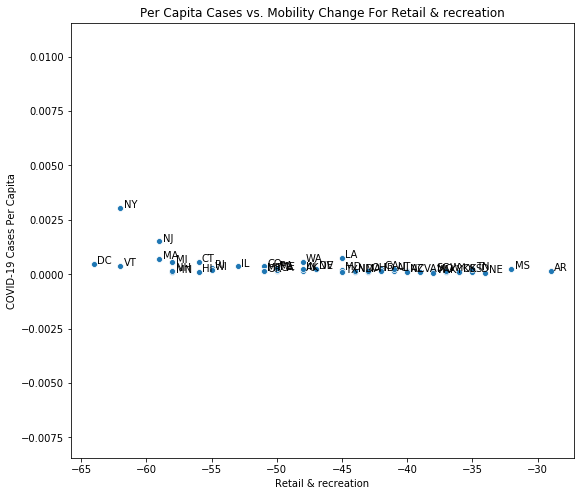

In [203]:
# set figsize and plot scatter
fig, ax = plt.subplots(figsize=(9,8))
mobility_cat = "Retail & recreation"
ax = sns.scatterplot(x=mobility_cat, y="positive_percap", data=mobility_merged)

# add annotations one by one with a loop
# https://python-graph-gallery.com/46-add-text-annotation-on-scatterplot/
for row in range(0, mobility_merged.shape[0]):
     ax.text(mobility_merged[mobility_cat].iloc[row]+0.25, 
            mobility_merged["positive_percap"].iloc[row], 
            mobility_merged["state"].iloc[row], 
            horizontalalignment='left', size='medium', color='black')

# ax.set_ylim((0, 0.001))
ax.set_title(f"Per Capita Cases vs. Mobility Change For {mobility_cat}")
ax.set_ylabel("COVID-19 Cases Per Capita");


As can see, this chart is not super helpful because of our two huge outliers, NY and NJ. Zooming in a bit, we get a better feel for the relationship between the change in visits to Retail/recreation venues and cases per capita. I've left NY and NJ in this plot purposefully so you can see how far they are from the other points. They are huge outliers, which is unsurprising. For the remainder of our mobility analysis, we'll exclude those two states.

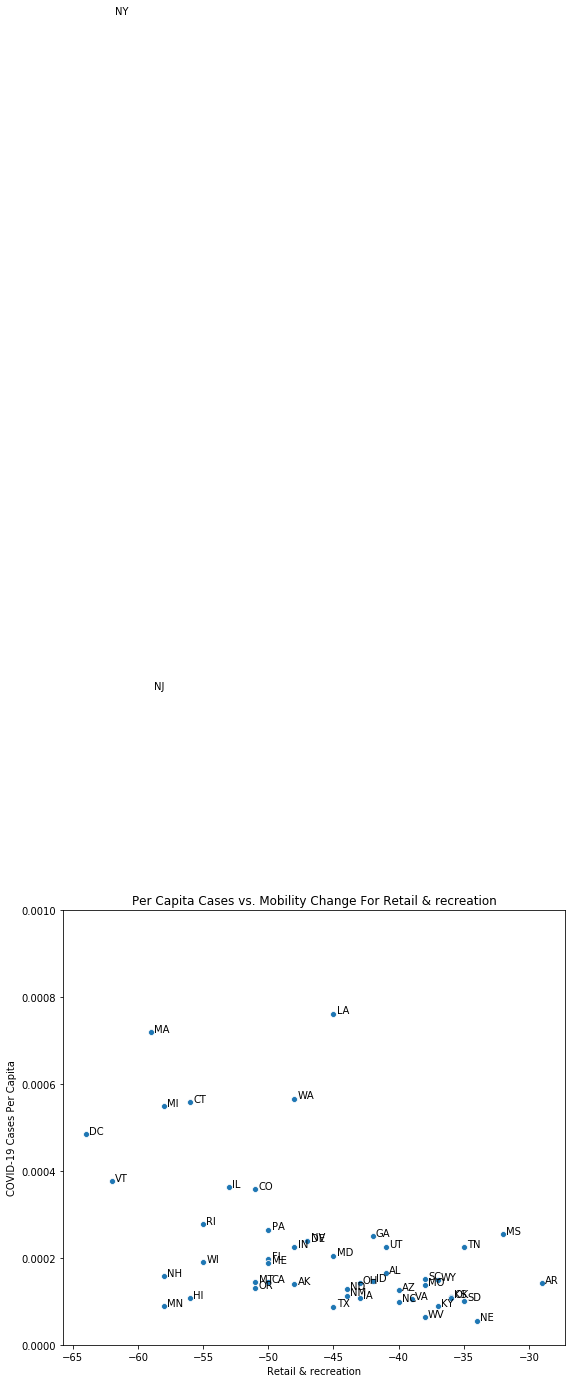

In [204]:
# set figsize and plot scatter
fig, ax = plt.subplots(figsize=(9,8))
mobility_cat = "Retail & recreation"
ax = sns.scatterplot(x=mobility_cat, y="positive_percap", data=mobility_merged)

# add annotations one by one with a loop
# https://python-graph-gallery.com/46-add-text-annotation-on-scatterplot/
for row in range(0, mobility_merged.shape[0]):
     ax.text(mobility_merged[mobility_cat].iloc[row]+0.25, 
            mobility_merged["positive_percap"].iloc[row], 
            mobility_merged["state"].iloc[row], 
            horizontalalignment='left', size='medium', color='black')

ax.set_ylim((0, 0.001))
ax.set_title(f"Per Capita Cases vs. Mobility Change For {mobility_cat}")
ax.set_ylabel("COVID-19 Cases Per Capita");


In [206]:
# remove NY and NJ
mobility_nooutliers = mobility_merged.loc[~mobility_merged["state"].isin(["NY", "NJ"])]

Now that we have removed outliers, let's examine the relationship beteween mobility and cases per capita for all mobility categories

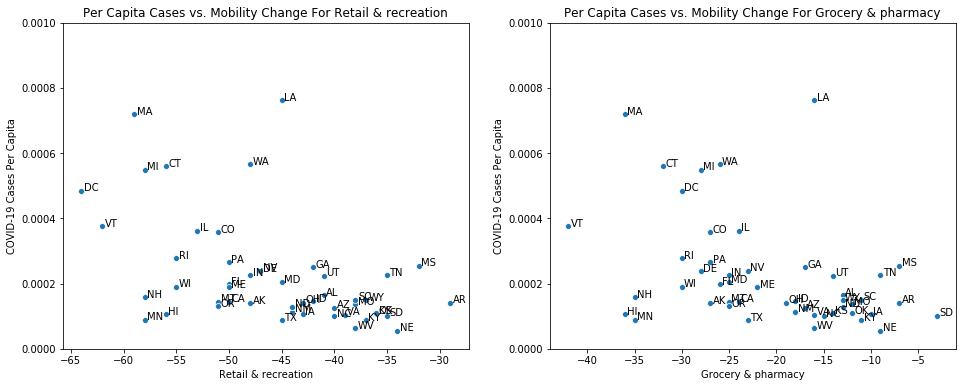

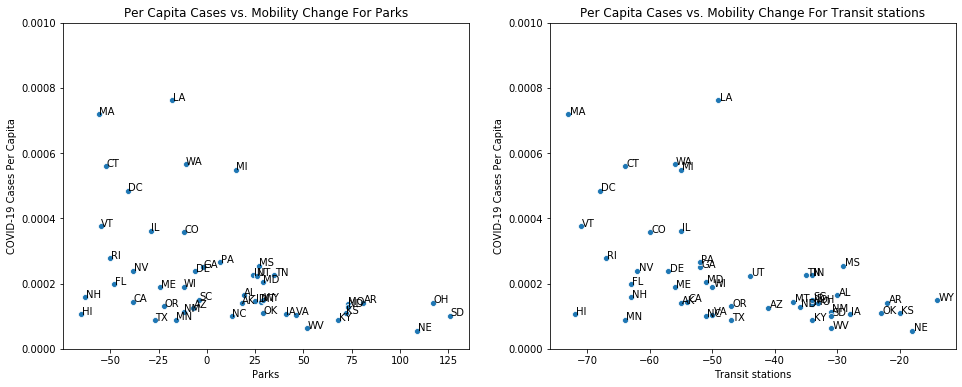

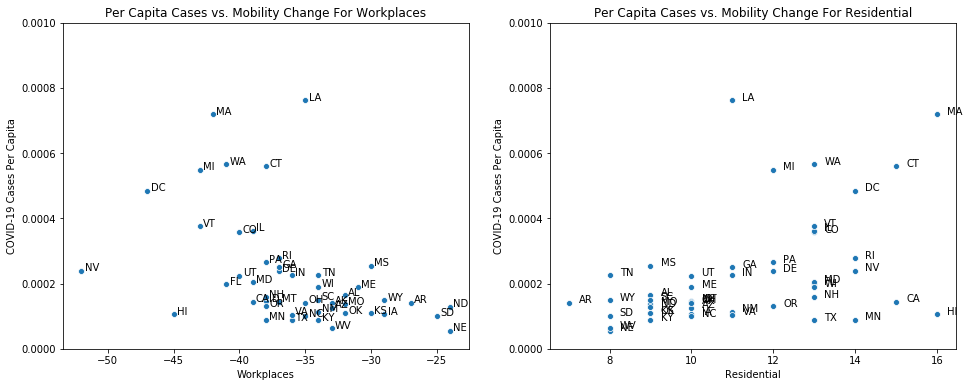

In [232]:
# set figsize and axes and plot scatter
fig, ax = plt.subplots(1, 2, figsize=(16,6))
mobility_cats = ["Retail & recreation", "Grocery & pharmacy", "Parks", "Transit stations",
                 "Workplaces", "Residential"]

for i in range (0, 2):
    i_ax = i-0
    ax[i_ax] = sns.scatterplot(x=mobility_cats[i], y="positive_percap", data=mobility_nooutliers, ax=ax[i_ax])

    # add annotations one by one with a loop
    # https://python-graph-gallery.com/46-add-text-annotation-on-scatterplot/
    for row in range(0, mobility_nooutliers.shape[0]):
        ax[i_ax].text(mobility_nooutliers[mobility_cats[i]].iloc[row]+0.25, 
                mobility_nooutliers["positive_percap"].iloc[row], 
                mobility_nooutliers["state"].iloc[row], 
                horizontalalignment='left', size='medium', color='black')

        ax[i_ax].set_ylim((0, 0.001))
        ax[i_ax].set_title(f"Per Capita Cases vs. Mobility Change For {mobility_cats[i]}")
        ax[i_ax].set_ylabel("COVID-19 Cases Per Capita");

fig, ax = plt.subplots(1, 2, figsize=(16,6))
for i in range (2, 4):
    i_ax = i-2
    ax[i_ax] = sns.scatterplot(x=mobility_cats[i], y="positive_percap", data=mobility_nooutliers, ax=ax[i_ax])

    # add annotations one by one with a loop
    # https://python-graph-gallery.com/46-add-text-annotation-on-scatterplot/
    for row in range(0, mobility_nooutliers.shape[0]):
        ax[i_ax].text(mobility_nooutliers[mobility_cats[i]].iloc[row]+0.25, 
                mobility_nooutliers["positive_percap"].iloc[row], 
                mobility_nooutliers["state"].iloc[row], 
                horizontalalignment='left', size='medium', color='black')

        ax[i_ax].set_ylim((0, 0.001))
        ax[i_ax].set_title(f"Per Capita Cases vs. Mobility Change For {mobility_cats[i]}")
        ax[i_ax].set_ylabel("COVID-19 Cases Per Capita");


fig, ax = plt.subplots(1, 2, figsize=(16,6))
for i in range (4, 6):
    i_ax = i-4
    ax[i_ax] = sns.scatterplot(x=mobility_cats[i], y="positive_percap", data=mobility_nooutliers, ax=ax[i_ax])

    # add annotations one by one with a loop
    # https://python-graph-gallery.com/46-add-text-annotation-on-scatterplot/
    for row in range(0, mobility_nooutliers.shape[0]):
        ax[i_ax].text(mobility_nooutliers[mobility_cats[i]].iloc[row]+0.25, 
                mobility_nooutliers["positive_percap"].iloc[row], 
                mobility_nooutliers["state"].iloc[row], 
                horizontalalignment='left', size='medium', color='black')

        ax[i_ax].set_ylim((0, 0.001))
        ax[i_ax].set_title(f"Per Capita Cases vs. Mobility Change For {mobility_cats[i]}")
        ax[i_ax].set_ylabel("COVID-19 Cases Per Capita");

In [249]:
correlations = []
correlations_nooutliers = []

for cat in mobility_cats:
    correlations.append({"mobility_category": cat,
                         "correlation": np.correlate(
                             mobility_merged[cat], 
                             mobility_merged["positive_percap"])[0]})
    correlations_nooutliers.append({"mobility_category": cat,
                         "correlation (outliers removed)": np.correlate(
                             mobility_nooutliers[cat], 
                             mobility_nooutliers["positive_percap"])[0]})

display(pd.DataFrame(correlations))
display(pd.DataFrame(correlations_nooutliers))

,mobility_category,correlation
0,Retail & recreation,-0.812776
1,Grocery & pharmacy,-0.404950
2,Parks,-0.259097
3,Transit stations,-0.875892
4,Workplaces,-0.619349
5,Residential,0.203963


,mobility_category,correlation (outliers removed)
0,Retail & recreation,-0.534187
1,Grocery & pharmacy,-0.257321
2,Parks,-0.061059
3,Transit stations,-0.562370
4,Workplaces,-0.412314
5,Residential,0.130902


#### Google search data
To conduct this analysis, we'll use [pytrends](https://github.com/GeneralMills/pytrends) a libary that allows you to query the GoogleTrends API for search data

In [293]:
import pytrends
from pytrends.request import TrendReq

# connect 
pyt = TrendReq(hl='en-US', tz=300)

Now, we can start examining searhes. Let us first examine searches for "coronavirus"

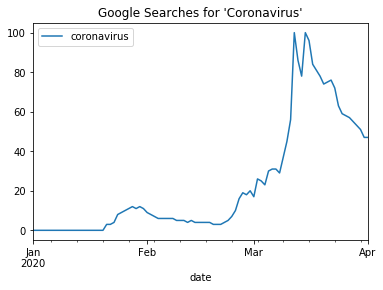

In [419]:
# build query: coronavirus searches starting at 2020
kw_list = ["coronavirus"]
pyt.build_payload(kw_list, cat=0, timeframe='2020-01-01 2020-04-01', geo='US', gprop='')

# interest over time
search_coronavirus = pyt.interest_over_time()
search_coronavirus.plot.line(y="coronavirus")
plt.title("Google Searches for 'Coronavirus'");


Another cool feature of the pytrends library is that you can fetch suggested queries related to your own. Let's fetch keywords similar to `coronavirus`. Keep in mind that these are the top queries similar queries over the time period: `2020-01-01` to `2020-04-01` within the United States.

In [359]:
pyt.related_queries()["coronavirus"]["top"]

,query,value
0,coronavirus update,100
1,coronavirus symptoms,89
2,coronavirus cases,87
3,coronavirus us,56
4,coronavirus map,53
5,corona,53
6,usa coronavirus,49
7,coronavirus news,45
8,coronavirus tips,35
9,corona virus,32


Let's plot the first few of these over time

In [420]:
# fetch top 5 related queries
related_5 = pyt.related_queries()["coronavirus"]["top"].iloc[:5]["query"].values

# build new query: related coronavirus queries
kw5_list = related_5
pyt.build_payload(kw5_list, cat=0, timeframe='2020-01-01 2020-04-01', geo='US', gprop='')
top5 = pyt.interest_over_time()
top5 = top5.reset_index()
top5["date"] = pd.to_datetime(top5["date"], infer_datetime_format=True) 

In [370]:
top5.tail()

,date,coronavirus update,coronavirus symptoms,coronavirus cases,coronavirus us,coronavirus map,isPartial
87,2020-03-28,41,20,56,26,28,False
88,2020-03-29,41,18,55,26,27,False
89,2020-03-30,37,17,46,24,25,False
90,2020-03-31,34,16,43,22,24,False
91,2020-04-01,33,16,41,22,25,False


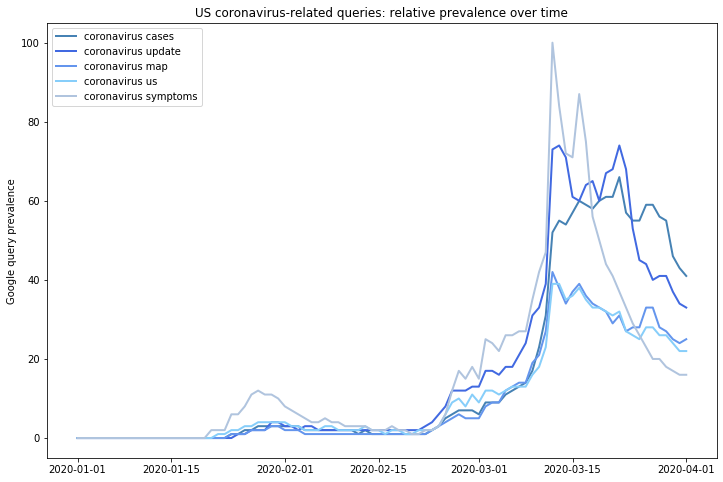

In [428]:
# now plot top 5 related queries
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot("date", "coronavirus cases", data=top5, color='steelblue', linewidth=2)
plt.plot("date", "coronavirus update", data=top5, color='royalblue', linewidth=2)
plt.plot("date", "coronavirus map", data=top5, color='cornflowerblue', linewidth=2) 
plt.plot("date", "coronavirus us", data=top5, color='lightskyblue', linewidth=2)
plt.plot("date", "coronavirus symptoms", data=top5, color='lightsteelblue', linewidth=2)
plt.legend(loc="upper left")
plt.ylabel("Google query prevalence")
plt.title("US coronavirus-related queries: relative prevalence over time");


Interesting - now let's overlay a plot of US coronavirus cases

In [424]:
# fetch US data and clean date
covid_us = covid_global.loc[covid_global["country"] == "US"]
covid_us["date"] =  pd.to_datetime(covid_us["date"], infer_datetime_format=True)  

# merge search
search_cases_us = top5.merge(covid_us, left_on="date", right_on="date", how="inner")[[
    "date", "coronavirus update", "coronavirus symptoms", "coronavirus cases", 
    "coronavirus us", "coronavirus map", "confirmed"]]


/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


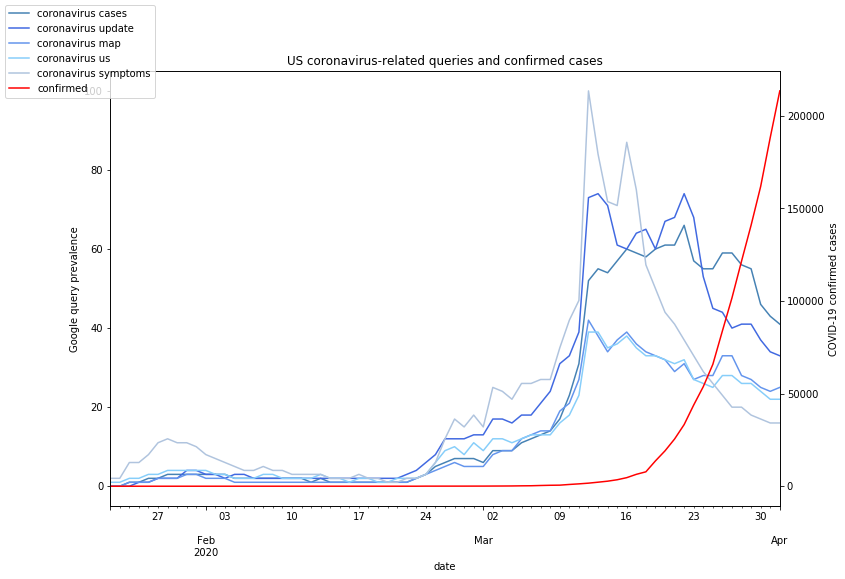

In [426]:
# now plot top 5 related queries with confirmed cases
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)
search_cases_us.plot(x="date", y="coronavirus cases", color="steelblue",  ax=ax1, legend=False)
search_cases_us.plot(x="date", y="coronavirus update", color="royalblue", ax=ax1, legend=False)
search_cases_us.plot(x="date", y="coronavirus map", color="cornflowerblue", ax=ax1, legend=False)
search_cases_us.plot(x="date", y="coronavirus us", color="lightskyblue", ax=ax1, legend=False)
search_cases_us.plot(x="date", y="coronavirus symptoms", color="lightsteelblue", ax=ax1, legend=False)
ax2 = ax1.twinx()
search_cases_us.plot(x="date", y="confirmed", ax=ax2, legend=False, color="r")

ax1.figure.legend(loc="upper left")
ax1.set_title("US coronavirus-related queries and confirmed cases")
ax1.set_ylabel("Google query prevalence")
ax2.set_ylabel("COVID-19 confirmed cases")
plt.show();

## Future ideas

#### Additional data
- Whether state went on lockdown
- COVID-19 Community Mobility Reports from [Google](https://www.google.com/covid19/mobility/)

#### Data engineering:
- How many days since lockdown